In [14]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import sys
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()
from glob import glob
sys.path.insert(0, "..") # This is when you load VirtualFleet functions
from virtualargofleet import Velocity, FloatConfiguration, VirtualFleet
import cmocean

In [2]:
import parcels
parcels.__version__

'3.1.2'

#let's make a June daily clim
files = glob('/home/ref-ocean-reanalysis/MEDSEA_MULTIYEAR_PHY_006_004/med-cmcc-cur-rean-d/*/06/*.nc')
files.sort()
ds = xr.open_mfdataset(files)
dsm = ds.groupby('time.dayofyear').mean()
dsm = dsm.rename({'dayofyear':'time'})
dsm['time'] = xr.DataArray(np.arange('2015-05-31','2015-07-01',dtype='datetime64[D]'), dims=["time"])
dsm.to_netcdf('JuneClim_UV_MEDSEA.nc')

In [3]:
files = glob('/espace/dataref/ref-ocean-reanalysis/MEDSEA_MULTIYEAR_PHY_006_004/med-cmcc-cur-rean-d/2019/06/*.nc')
files.sort()
print(files[0],'\n to \n',files[-1])
ds = xr.open_dataset(files[0])
ds

/espace/dataref/ref-ocean-reanalysis/MEDSEA_MULTIYEAR_PHY_006_004/med-cmcc-cur-rean-d/2019/06/20190601_d-CMCC--RFVL-MFSe3r1-MED-b20200901_re-sv01.00.nc 
 to 
 /espace/dataref/ref-ocean-reanalysis/MEDSEA_MULTIYEAR_PHY_006_004/med-cmcc-cur-rean-d/2019/06/20190630_d-CMCC--RFVL-MFSe3r1-MED-b20200901_re-sv01.00.nc


<xarray.Dataset> Size: 436MB
Dimensions:  (time: 1, depth: 141, lat: 380, lon: 1016)
Coordinates:
  * depth    (depth) float32 564B 1.018 3.166 5.465 ... 5.646e+03 5.754e+03
  * lon      (lon) float32 4kB -6.0 -5.958 -5.917 -5.875 ... 36.21 36.25 36.29
  * lat      (lat) float32 2kB 30.19 30.23 30.27 30.31 ... 45.9 45.94 45.98
  * time     (time) datetime64[ns] 8B 2019-06-01T12:00:00
Data variables:
    vo       (time, depth, lat, lon) float32 218MB ...
    uo       (time, depth, lat, lon) float32 218MB ...
Attributes:
    title:          Horizontal Velocity (3D) - Daily Mean
    field_type:     daily_mean_centered_at_time_field
    source:         MFS E3R1
    institution:    Centro Euro-Mediterraneo sui Cambiamenti Climatici - CMCC...
    contact:        servicedesk.cmems@mercator-ocean.eu
    references:     Please check in CMEMS catalogue the INFO section for prod...
    comment:        Please check in CMEMS catalogue the INFO section for prod...
    Conventions:    CF-1.0
    bulletin_date:  20200901
    bulletin_type:  reanalysis

In [4]:
root = "/espace/dataref/ref-ocean-reanalysis/MEDSEA_MULTIYEAR_PHY_006_004/med-cmcc-cur-rean-d/2019/06/"
filenames = {'U': root + "/*.nc",
              'V': root + "/*.nc"}
variables = {'U':'uo', 'V':'vo'}
dimensions = {'time': 'time', 'depth':'depth', 'lat': 'lat', 'lon': 'lon'}
VELfield = Velocity(model='custom',
                    src=filenames,
                    variables=variables,
                    dimensions=dimensions)

(1016, 380)


In [5]:
fieldset = VELfield.fieldset
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1.)

np.float64(86400.0)

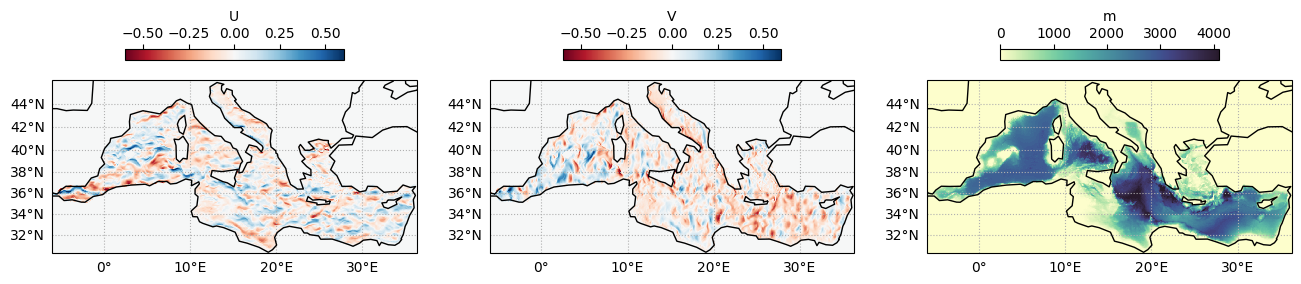

In [15]:
fig=plt.figure(figsize=(16,5))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 3, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='U')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 2, projection=pr2)
a=ax1.pcolormesh(fieldset.V.grid.lon,fieldset.V.grid.lat,fieldset.V.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='V')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 3, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=cmocean.cm.deep,vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
plt.colorbar(a,location='top',shrink=0.6,label='m')

In [26]:
mission = FloatConfiguration('default')
mission.update('parking_depth', 1500)
mission.update('profile_depth', 4000)
mission.update('cycle_duration', 5*24)
mission

<FloatConfiguration><default>
- cycle_duration (Maximum length of float complete cycle): 120.0 [hours]
- life_expectancy (Maximum number of completed cycle): 200 [cycle]
- parking_depth (Drifting depth): 1500.0 [m]
- profile_depth (Maximum profile depth): 4000.0 [m]
- vertical_speed (Vertical profiling speed): 0.09 [m/s]

In [17]:
# Set min/max depth for float conf, this is to make sure Parcels doesn't struggle 
min_depth = np.ceil(ds['depth'].min(['depth']).min().values)
max_depth = int(fieldset.gridset.grids[0].depth.max() / 100)*100
print(min_depth,max_depth)

2.0 5700


In [18]:
fieldset.add_constant("vf_surface",min_depth)
fieldset.add_constant("vf_bottom", max_depth)

In [23]:
lon0, lat0 = 5, 38  # Center of the box
#lon0, lat0 = 7.83082, 43.3797  # Center of the box

Lx, Ly = 0.5, 0.5 # Size of the box
fbox = [lon0-Lx/2,lat0-Ly/2,lon0+Lx/2,lat0+Ly/2]
coords=np.array(list(itertools.product(np.arange(fbox[0],fbox[2],.1),np.arange(fbox[1],fbox[3],.1))))
lon = coords[:,0]
lat = coords[:,1]
nfloats=len(lon)
dpt = np.linspace(min_depth, min_depth, nfloats) #1m depth
tim = np.array(['2019-06-02' for i in range(nfloats)],dtype='datetime64')
my_plan = {'lat': lat, 
           'lon': lon, 
           'time': tim, 
           'depth':dpt}

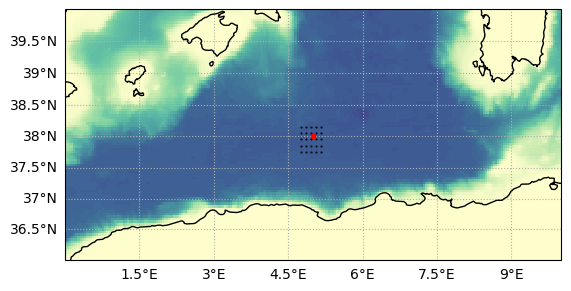

In [24]:
fig=plt.figure()
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 1, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=cmocean.cm.deep,vmin=0)
#b=ax1.contourf(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],np.arange(990,1010),transform=pr1)
ax1.coastlines(resolution='10m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1.plot(my_plan['lon'],my_plan['lat'],'k.',markersize=1,transform=pr1)
ax1.set_extent([lon0-5,lon0+5,lat0-2,lat0+2])
ax1.plot(lon0,lat0,'r.',transform=pr1)

In [27]:
VFleet = VirtualFleet(plan=my_plan, fieldset=VELfield, mission=mission, verbose_events=False)
VFleet

<VirtualFleet>
- 25 floats in the deployment plan
- No simulation performed

In [28]:
VFleet.simulate(
    duration=timedelta(days=25),
    step=timedelta(minutes=5),
    record=timedelta(minutes=60),
    output_folder="/home1/scratch/kbalem",
)

/home/kbalem/Bureau/VirtualFleet/knotebooks/../virtualargofleet/virtualargofleet.py:361: UserWarning: Simulation will be saved in : /home1/scratch/kbalem/fp3xcrrp.zarr
  warnings.warn(output_msg)


INFO: Output files are stored in /home1/scratch/kbalem/fp3xcrrp.zarr.
100%|███████████████████████████████████████████████████████████████████████████████| 2160000.0/2160000.0 [23:32<00:00, 1529.63it/s]


<VirtualFleet>
- 25 floats in the deployment plan
- Number of simulation(s): 1
- Last simulation meta-data:
	- Duration: 25d 00h 00m 00s
	- Data recording every: 01h 00m
	- Trajectory file: /home1/scratch/kbalem/fp3xcrrp.zarr
	- Execution time: 00d 00h 23m 35s
	- Executed on: L-BR-LOPS-P26

In [29]:
dout=xr.open_zarr('/home1/scratch/kbalem/fp3xcrrp.zarr')
dout.load()

<xarray.Dataset> Size: 603kB
Dimensions:       (trajectory: 25, obs: 600)
Coordinates:
  * obs           (obs) int32 2kB 0 1 2 3 4 5 6 ... 593 594 595 596 597 598 599
  * trajectory    (trajectory) int64 200B 50 51 52 53 54 55 ... 70 71 72 73 74
Data variables:
    cycle_age     (trajectory, obs) float32 60kB 300.0 3.9e+03 ... 4.287e+05
    cycle_number  (trajectory, obs) float64 120kB 1.0 1.0 1.0 ... 5.0 5.0 5.0
    cycle_phase   (trajectory, obs) float64 120kB 0.0 0.0 0.0 ... 4.0 4.0 4.0
    lat           (trajectory, obs) float32 60kB 37.75 37.75 ... 38.23 38.22
    lon           (trajectory, obs) float32 60kB 4.75 4.752 ... 4.673 4.668
    time          (trajectory, obs) datetime64[ns] 120kB 2019-06-02 ... 2019-...
    z             (trajectory, obs) float32 60kB 2.0 326.0 650.0 ... 2.092 2.092
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ArgoParticleArgoFloatKernelAdvectionRK4KeepInWate...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

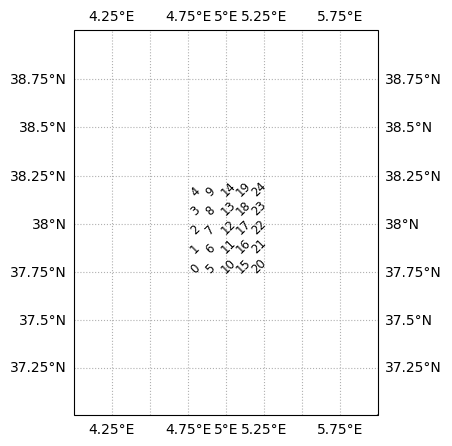

In [33]:
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
fig=plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(projection=pr2)
for i in range(len(dout.trajectory)):
    ax1.text(dout.isel(obs=0)['lon'].values[i],dout.isel(obs=0)['lat'].values[i],
             (dout.isel(obs=0)['trajectory'].values[i] - dout.isel(obs=0)['trajectory'].values[0]).astype('U3'),
             transform=pr1,
             fontsize='small',
             rotation=45.)
ax1.set_extent([lon0-1,lon0+1,lat0-1,lat0+1])
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)

In [34]:
extent = [float(dout['lon'].min()-.5),
          float(dout['lon'].max()+.5),
          float(dout['lat'].min()-.5),
          float(dout['lat'].max()+.5)]

In [36]:
cmap = plt.get_cmap('spring',25)

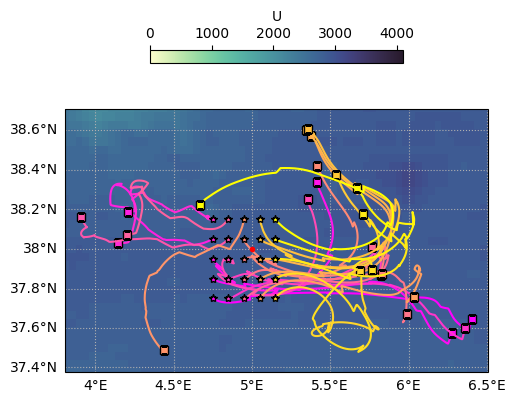

In [40]:
fig=plt.figure(figsize=(12,12))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 2, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,vmin=0,cmap=cmocean.cm.deep)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'*',color=cmap(t),markeredgecolor='k',transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),color=cmap(t),transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'s',color=cmap(t),markeredgecolor='k',transform=pr1)
plt.colorbar(a,location='top',shrink=0.6,label='U')
ax1.set_extent(extent)
ax1.plot(lon0,lat0,'r.',transform=pr1,zorder=10)

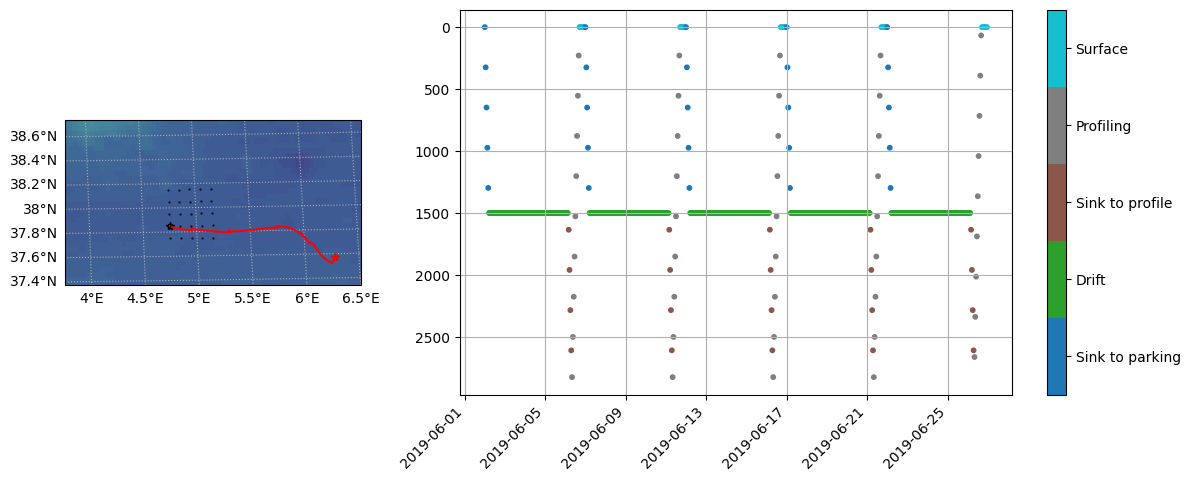

In [41]:
tr=1

fig=plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1,2,width_ratios=[.6,1.4])
pr1=ccrs.PlateCarree()
pr2=ccrs.LambertAzimuthalEqualArea()
ax1 = fig.add_subplot(gs[0], projection=pr2)
ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,vmin=0,cmap=cmocean.cm.deep)
#ax1.contourf(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],np.arange(990,1010),transform=pr1)
ax1.coastlines(resolution='10m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False

ax1.plot(dout['lon'].isel(trajectory=tr,obs=0),dout['lat'].isel(trajectory=tr,obs=0),'k*',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr),dout['lat'].isel(trajectory=tr),'r',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr,obs=-1),dout['lat'].isel(trajectory=tr,obs=-1),'r*',transform=pr1)
extent = [float(dout['lon'].min()-.1),
          float(dout['lon'].max()+.1),
          float(dout['lat'].min()-.1),
          float(dout['lat'].max()+.1)]
ax1.set_extent(extent)
ax1.plot(my_plan['lon'],my_plan['lat'],'k.',markersize=1,transform=pr1)

ax = fig.add_subplot(gs[1])
a=ax.scatter(dout['time'].isel(trajectory=tr),dout['z'].isel(trajectory=tr),s=10,c=dout['cycle_phase'].isel(trajectory=tr),cmap=plt.get_cmap('tab10',5),vmin=0,vmax=5)
ax.invert_yaxis()
_=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(':')
#ax.set_xlim([np.datetime64('2011-01-15'),np.datetime64('2011-01-16')])
cb=plt.colorbar(a,ticks=[0.5,1.5,2.5,3.5,4.5])
cb.set_ticklabels(['Sink to parking','Drift','Sink to profile','Profiling','Surface'])